In [1]:
import cimpy
from cimpy import CIMpyToDPsim
from cimpy.CIMpyToDPsim import Domain
from cimpy.cgmes_v2_4_15.Base import short_profile_name
import os
from pathlib import Path

import sys
sys.path.insert(0,'/home/mmo-cya/dpsim/build')
import dpsimpy



example_dir = Path(os.path.join('../cimpy/examples/sampledata/IEEE14_Data')).resolve()

test_files = []
for file in example_dir.glob('*.xml'):
    test_files.append(str(file.absolute()))

imported_result = cimpy.cim_import(test_files, 'cgmes_v2_4_15')



TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
DL
TTTTTTTTTT

In [2]:
imported_result['topology']['_8e72c18c-4b49-b84e-eeac-3eef44168805'].nominalVoltage

11.0

In [3]:
imported_result['topology']['_8e72c18c-4b49-b84e-eeac-3eef44168805'].name

'11.00 kV'

[15:43:27.252763 _69a8be1c-fb73-41dc-9fc0-f708e25bc37d warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.252794 _69a8be1c-fb73-41dc-9fc0-f708e25bc37d warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[15:43:27.253079 _a92e9987-e2ab-4f97-89b1-c559089018b2 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.253085 _a92e9987-e2ab-4f97-89b1-c559089018b2 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[15:43:27.253374 _bbfef80d-4008-4bfa-803a-4072f7a0c666 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[15:43:27.253637 _5121e210-8cf6-43bf-83a3-c6d36b8261f3 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[15:43:27.253943 _93eb61e0-333c-4f9d-9ff0-04af8ccb117b warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.253948 _93eb61e0-333c-4f9d-9ff0-04af8ccb117b warning] Zero value for Conductance, setti

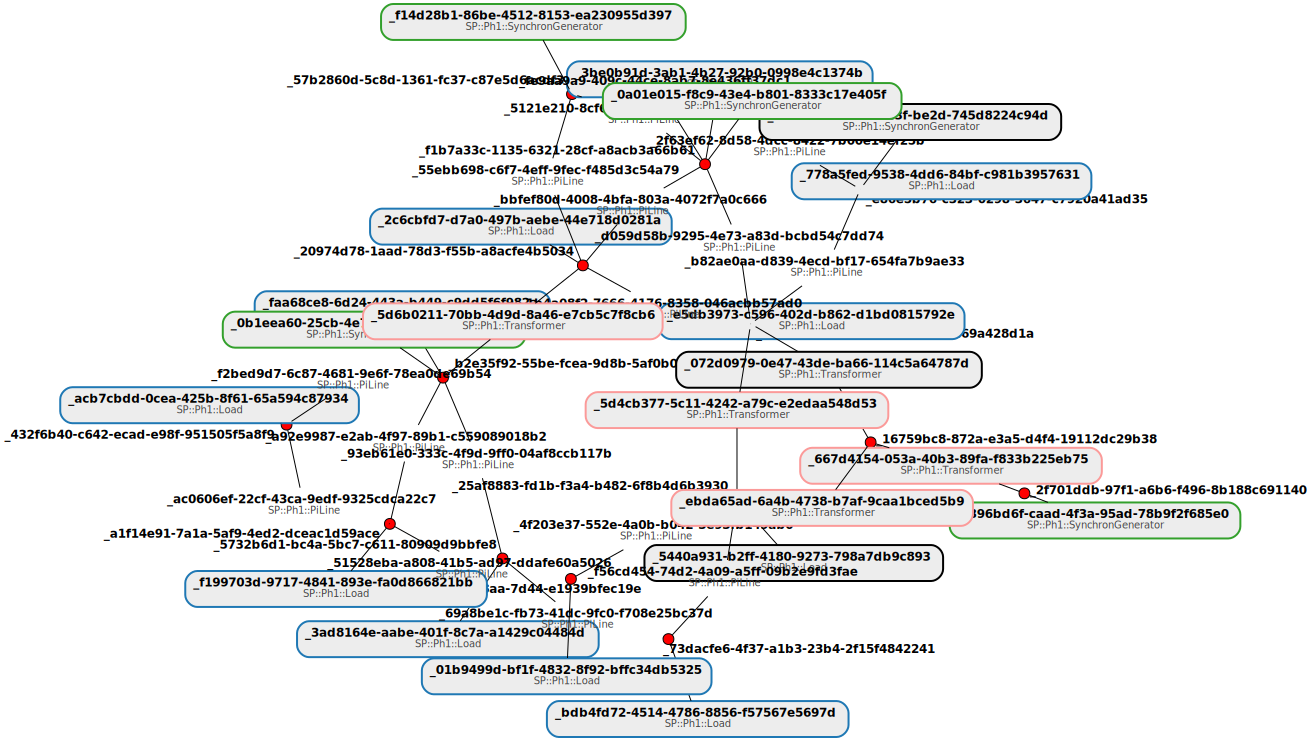

In [4]:
system_SP , K = CIMpyToDPsim.CIMpyToDPsim(imported_result, Domain.PF)
system_SP

CIMContentHandler: Note: 0 out of 898 tasks remain unresolved!


[15:43:27.432885 Line_0006_0012 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.433483 Line_0006_0011 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.433638 Line_0006_0013 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.434474 Line_0010_0011 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.434634 Line_0009_0010 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.437145 Line_0009_0014 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.437626 Line_0012_0013 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]
[15:43:27.438058 Line_0013_0014 warning] Zero value for Capacitance, setting default value of C=1e-12 [F]


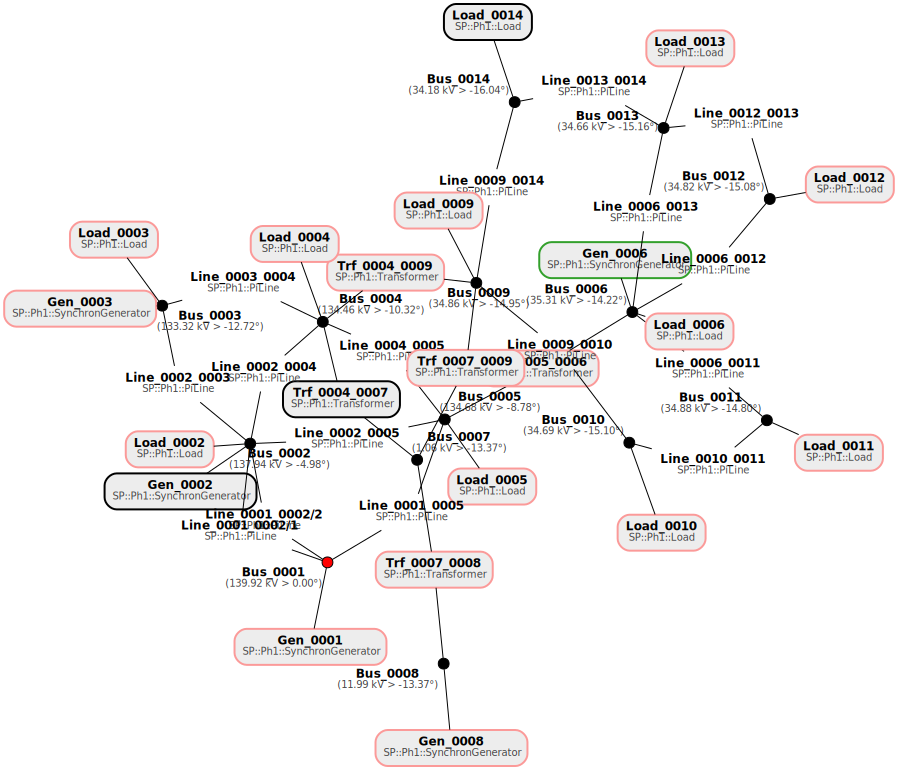

In [5]:

system= dpsimpy.SystemTopology(60)


reader = dpsimpy.CIMReader("system")
system = reader.loadCIM(60, test_files, dpsimpy.Domain.SP, dpsimpy.PhaseType.Single, dpsimpy.GeneratorType.PVNode)
system